In [1]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from tqdm import tqdm


In [10]:

df = pd.read_csv("Multimodal_FakeNews_Sample_1999_Clean.csv")
# df = df[['text', 'label']] 
df['label'] = df['label'].map({'real': 1, 'fake': 0})
df.head()



,ID,text,top_img,label,image_filename
0,gossipcop-841625,Mama June Shannon made a grand entrance as she...,https://i.dailymail.co.uk/i/pix/2017/04/08/06/...,1,gossipcop-841625.jpg
1,gossipcop-844265,Luann D’Agostino‘s daughter Victoria de Lessep...,https://people.com/thmb/yZbppM3Vrd6MgO8-mlPXYs...,1,gossipcop-844265.jpg
2,gossipcop-843746,"Photography by​ Philip Cosores\n\nWell, they d...",https://consequence.net/wp-content/uploads/201...,1,gossipcop-843746.jpg
3,gossipcop-3515239961,Play video content\n\nA video that's surfaced ...,https://imagez.tmz.com/image/07/16by9/2017/12/...,0,gossipcop-3515239961.jpg
4,gossipcop-845311,"Try again, please. Blake Lively shut down a re...",https://www.usmagazine.com/wp-content/uploads/...,1,gossipcop-845311.jpg


In [11]:

def tokenize(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.lower().split()

tokenized_texts = [tokenize(t) for t in df['text']]


In [12]:

all_tokens = [token for tokens in tokenized_texts for token in tokens]
vocab = {word: idx + 1 for idx, (word, _) in enumerate(Counter(all_tokens).most_common())}
vocab['<PAD>'] = 0 


with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)


In [13]:

encoded_texts = [[vocab.get(word, 0) for word in tokens] for tokens in tokenized_texts]

seq_length = 100
padded_texts = pad_sequence([torch.tensor(seq[:seq_length]) if len(seq) >= seq_length else 
                             torch.cat([torch.tensor(seq), torch.zeros(seq_length - len(seq))])
                             for seq in encoded_texts], batch_first=True)


In [14]:
labels = torch.tensor(df['label'].values).float()


In [15]:
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    padded_texts, labels, test_size=0.3, stratify=labels, shuffle=True, random_state=42
)

In [16]:
X_train_text

tensor([[  46, 1220,    1,  ...,    1,  585,   13],
        [1798, 1145,  539,  ...,   16,  137,   20],
        [   1,  972, 3681,  ...,  109, 1037,  982],
        ...,
        [   1,  124,  760,  ...,    1,  418,  677],
        [5134,  319,   14,  ...,  345,    4, 7426],
        [   1, 5558, 2085,  ...,  772,  186,    3]])

In [17]:

train_dataset = TensorDataset(X_train_text, y_train_text)
test_dataset = TensorDataset(X_test_text, y_test_text)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
X_train_text


tensor([[  46, 1220,    1,  ...,    1,  585,   13],
        [1798, 1145,  539,  ...,   16,  137,   20],
        [   1,  972, 3681,  ...,  109, 1037,  982],
        ...,
        [   1,  124,  760,  ...,    1,  418,  677],
        [5134,  319,   14,  ...,  345,    4, 7426],
        [   1, 5558, 2085,  ...,  772,  186,    3]])

In [45]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x.long())
        _, (hn, _) = self.lstm(embedded)
        out = self.fc(hn[-1])
        return self.sigmoid(out).squeeze()


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(vocab_size=len(vocab), embed_dim=128, hidden_dim=64).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []

for epoch in range(10):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predictions = (outputs >= 0.5).float()
        correct += (predictions == targets).sum().item()
        total += targets.size(0)

    acc = correct / total
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f} - Accuracy: {acc:.4f}")


Epoch 1: 100%|██████████| 44/44 [00:02<00:00, 16.87it/s]


Epoch 1 - Loss: 30.5392 - Accuracy: 0.5197


Epoch 2: 100%|██████████| 44/44 [00:02<00:00, 15.86it/s]


Epoch 2 - Loss: 29.1415 - Accuracy: 0.6576


Epoch 3: 100%|██████████| 44/44 [00:04<00:00, 10.63it/s]


Epoch 3 - Loss: 26.9936 - Accuracy: 0.7098


Epoch 4: 100%|██████████| 44/44 [00:03<00:00, 11.15it/s]


Epoch 4 - Loss: 22.7542 - Accuracy: 0.7784


Epoch 5: 100%|██████████| 44/44 [00:03<00:00, 11.31it/s]


Epoch 5 - Loss: 16.6165 - Accuracy: 0.8442


Epoch 6: 100%|██████████| 44/44 [00:03<00:00, 11.52it/s]


Epoch 6 - Loss: 13.0881 - Accuracy: 0.8914


Epoch 7: 100%|██████████| 44/44 [00:03<00:00, 11.64it/s]


Epoch 7 - Loss: 8.8416 - Accuracy: 0.9085


Epoch 8: 100%|██████████| 44/44 [00:04<00:00,  8.91it/s]


Epoch 8 - Loss: 6.3112 - Accuracy: 0.9271


Epoch 9: 100%|██████████| 44/44 [00:03<00:00, 12.72it/s]


Epoch 9 - Loss: 4.7570 - Accuracy: 0.9407


Epoch 10: 100%|██████████| 44/44 [00:03<00:00, 12.98it/s]

Epoch 10 - Loss: 5.6639 - Accuracy: 0.9392


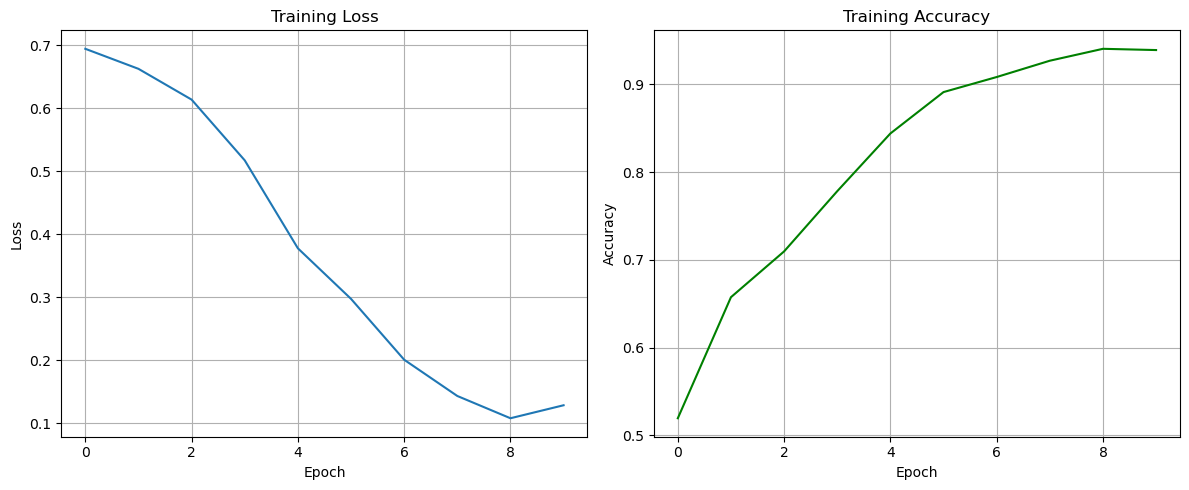

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy', color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


In [21]:
torch.save(model.state_dict(), "LSTM_model.pth")


# Traing Image Model

In [29]:
import pandas as pd
import os

Dataset_Image = df[["top_img","image_filename","label"]]

image_dir = "./fake_news_images_1999"

Dataset_Image["image_path"] = Dataset_Image["image_filename"].apply(lambda x: os.path.join(image_dir, x))
Dataset_Image = Dataset_Image[Dataset_Image["image_path"].apply(os.path.exists)]  # Only keep valid files
Dataset_Image

C:\Users\Owner\AppData\Local\Temp\ipykernel_39648\1087822780.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataset_Image["image_path"] = Dataset_Image["image_filename"].apply(lambda x: os.path.join(image_dir, x))


,top_img,image_filename,label,image_path
0,https://i.dailymail.co.uk/i/pix/2017/04/08/06/...,gossipcop-841625.jpg,1,./fake_news_images_1999\gossipcop-841625.jpg
1,https://people.com/thmb/yZbppM3Vrd6MgO8-mlPXYs...,gossipcop-844265.jpg,1,./fake_news_images_1999\gossipcop-844265.jpg
2,https://consequence.net/wp-content/uploads/201...,gossipcop-843746.jpg,1,./fake_news_images_1999\gossipcop-843746.jpg
3,https://imagez.tmz.com/image/07/16by9/2017/12/...,gossipcop-3515239961.jpg,0,./fake_news_images_1999\gossipcop-3515239961.jpg
4,https://www.usmagazine.com/wp-content/uploads/...,gossipcop-845311.jpg,1,./fake_news_images_1999\gossipcop-845311.jpg
...,...,...,...,...
1994,https://i0.wp.com/www.thewrap.com/wp-content/u...,gossipcop-847387.jpg,1,./fake_news_images_1999\gossipcop-847387.jpg
1995,https://www.closerweekly.com/wp-content/upload...,gossipcop-285127609.jpg,0,./fake_news_images_1999\gossipcop-285127609.jpg
1996,https://i.insider.com/5ae86785bd967141008b4682...,gossipcop-847284.jpg,1,./fake_news_images_1999\gossipcop-847284.jpg
1997,https://i.dailymail.co.uk/1s/2018/12/06/00/706...,gossipcop-849293.jpg,1,./fake_news_images_1999\gossipcop-849293.jpg


In [30]:
Dataset_Image["image_path"] = Dataset_Image["image_path"].apply(os.path.normpath)
Dataset_Image

,top_img,image_filename,label,image_path
0,https://i.dailymail.co.uk/i/pix/2017/04/08/06/...,gossipcop-841625.jpg,1,fake_news_images_1999\gossipcop-841625.jpg
1,https://people.com/thmb/yZbppM3Vrd6MgO8-mlPXYs...,gossipcop-844265.jpg,1,fake_news_images_1999\gossipcop-844265.jpg
2,https://consequence.net/wp-content/uploads/201...,gossipcop-843746.jpg,1,fake_news_images_1999\gossipcop-843746.jpg
3,https://imagez.tmz.com/image/07/16by9/2017/12/...,gossipcop-3515239961.jpg,0,fake_news_images_1999\gossipcop-3515239961.jpg
4,https://www.usmagazine.com/wp-content/uploads/...,gossipcop-845311.jpg,1,fake_news_images_1999\gossipcop-845311.jpg
...,...,...,...,...
1994,https://i0.wp.com/www.thewrap.com/wp-content/u...,gossipcop-847387.jpg,1,fake_news_images_1999\gossipcop-847387.jpg
1995,https://www.closerweekly.com/wp-content/upload...,gossipcop-285127609.jpg,0,fake_news_images_1999\gossipcop-285127609.jpg
1996,https://i.insider.com/5ae86785bd967141008b4682...,gossipcop-847284.jpg,1,fake_news_images_1999\gossipcop-847284.jpg
1997,https://i.dailymail.co.uk/1s/2018/12/06/00/706...,gossipcop-849293.jpg,1,fake_news_images_1999\gossipcop-849293.jpg


In [31]:
import os
print(os.path.exists(Dataset_Image["image_path"][0]))

True


In [32]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(Dataset_Image, test_size=0.2, stratify=Dataset_Image['label'], random_state=42)


In [48]:
# Image Classification
import torch
from torchvision import transforms
torch.manual_seed(1)

transform_imgs = transforms.Compose([
    transforms.Resize(size=(224, 224), antialias=True),
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=.5, contrast=.2, saturation=.2),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    transforms.RandomAdjustSharpness(sharpness_factor=.2),
    # v2.JPEG((5, 50)),
    # transforms.ToPILImage(),  # Convert to tensor, only needed if you had a PIL image

    # transforms.ToDtype(torch.float32, scale=True),  # Normalize expects float input,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalization will be done later right before training the model to makesaved images visually interpreetable
])


In [34]:
# Define custom Dataset -> this will help you load images from your csv file
class CustomTrainingData(Dataset):
    def __init__(self, csv_df, class_list, transform=None):
        self.df = csv_df
        self.transform = transform
        self.class_list = class_list

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        image = Image.open(self.df.iloc[index].image_path).convert('RGB')
        label = self.class_list.index(self.df.iloc[index].label)

        if self.transform:
            image = self.transform(image)

        return image, label

In [35]:
from torch.utils.data import DataLoader

train_dataset = CustomTrainingData(train_df, class_list=[0, 1], transform=transforms)
test_dataset = CustomTrainingData(test_df, class_list=[0, 1], transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# MobileNetV2

In [36]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


c:\Users\Owner\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Owner\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
def train_model(model, train_loader, test_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        loop = tqdm(enumerate(train_loader), total=len(train_loader),desc=f"Epoch {epoch+1}") # create a progress bar
        for batch_idx, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        acc = correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.4f}")

        # Validation
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_correct += (outputs.argmax(1) == labels).sum().item()
        val_acc = val_correct / len(test_loader.dataset)
        print(f"Validation Accuracy = {val_acc:.4f}")


In [52]:
train_model(model, train_loader, test_loader, epochs=10)

Epoch 1: 100%|██████████| 50/50 [01:04<00:00,  1.30s/it]


Epoch 1: Loss = 24.1704, Accuracy = 0.7749
Validation Accuracy = 0.5775


Epoch 2: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Epoch 2: Loss = 17.7613, Accuracy = 0.8487
Validation Accuracy = 0.6375


Epoch 3: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


Epoch 3: Loss = 12.5253, Accuracy = 0.8999
Validation Accuracy = 0.5925


Epoch 4: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Epoch 4: Loss = 9.9459, Accuracy = 0.9287
Validation Accuracy = 0.6175


Epoch 5: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


Epoch 5: Loss = 8.4584, Accuracy = 0.9337
Validation Accuracy = 0.6050


Epoch 6: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


Epoch 6: Loss = 7.1164, Accuracy = 0.9487
Validation Accuracy = 0.6150


Epoch 7: 100%|██████████| 50/50 [00:58<00:00,  1.18s/it]


Epoch 7: Loss = 4.8883, Accuracy = 0.9644
Validation Accuracy = 0.5750


Epoch 8: 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Epoch 8: Loss = 4.8529, Accuracy = 0.9700
Validation Accuracy = 0.5950


Epoch 9: 100%|██████████| 50/50 [01:13<00:00,  1.48s/it]


Epoch 9: Loss = 4.8952, Accuracy = 0.9644
Validation Accuracy = 0.5975


Epoch 10: 100%|██████████| 50/50 [01:05<00:00,  1.32s/it]


Epoch 10: Loss = 4.0031, Accuracy = 0.9719
Validation Accuracy = 0.5875


In [ ]:
#visualization of both accuracy and loss


In [55]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [53]:
torch.save(model.state_dict(), "mobilenetv2_fakenews.pth")

# Apply L-Fusion

Liscense: https://github.com/facebookresearch/multimodal/blob/main/LICENSE

In [2]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.
#
# This source code is licensed under the BSD-style license found in the
# LICENSE file in the root directory of this source tree.

from typing import Dict

import torch
from torch import nn


class LateFusion(nn.Module):
    """A generic architecture for late fusion multimodal models.

    A late fusion model contains separate encoders for each modality,
    followed by a fusion layer and then a head module. For an example of a
    late fusion model, see the TorchMultimodal implementation of the cnn-lstm
    multimodal classifier (cnn_lstm.py)

    Args:
        encoders (ModuleDict): Dictionary mapping modalities to their respective
            encoders.

    Inputs:
        modalities (Dict[str, Tensor]): A dictionary mapping modalities to
            their tensor representations.
    """

    def __init__(
        self,
        encoders: nn.ModuleDict,
        fusion_module: nn.Module,
        head_module: nn.Module,
    ):
        super().__init__()
        # Sort encoders by key on init for consistency
        self.encoders = nn.ModuleDict({k: encoders[k] for k in sorted(encoders.keys())})
        self.fusion_module = fusion_module
        self.head_module = head_module

    def forward(self, modalities: Dict[str, torch.Tensor]) -> torch.Tensor:
        embeddings = {}
        for key, encoder in self.encoders.items():
            assert key in modalities, f"{key} missing in input"
            embeddings[key] = encoder(modalities[key])
        fused = self.fusion_module(embeddings)
        return self.head_module(fused)

In [ ]:
frames = [df, Dataset_Image["image_path"]]

Finalized_Df = pd.concat(frames, axis=1)

Finalized_Df

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
import re
from PIL import Image
import random

#  Reproducibility 
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

#  Vocab building and tokenizer 
def build_vocab(texts):
    tokens = []
    for text in texts:
        tokens += re.sub(r'[^a-zA-Z0-9\s]', '', str(text)).lower().split()
    vocab = {word: idx+1 for idx, word in enumerate(set(tokens))}
    vocab['<PAD>'] = 0
    return vocab

def simple_tokenizer(text, vocab, seq_length=128):
    tokens = re.sub(r'[^a-zA-Z0-9\s]', '', str(text)).lower().split()
    ids = [vocab.get(word, 0) for word in tokens]
    if len(ids) < seq_length:
        ids += [0] * (seq_length - len(ids))
    else:
        ids = ids[:seq_length]
    return torch.tensor(ids, dtype=torch.long)

#  Image transforms 
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#  Dataset 
class MultimodalDataset(Dataset):
    def __init__(self, df, vocab, seq_length=128, image_transform=None, text_col="text", label_col="label"):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.seq_length = seq_length
        self.image_transform = image_transform
        self.text_col = text_col
        self.label_col = label_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Image
        image = Image.open(row.image_path).convert("RGB")
        if self.image_transform:
            image = self.image_transform(image)
        # Text
        text_tensor = simple_tokenizer(row[self.text_col], self.vocab, self.seq_length)
        # Label
        label = torch.tensor(int(row[self.label_col]), dtype=torch.long)
        return {"image": image, "text": text_tensor}, label

#  LSTM Text Encoder 
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        return h_n[-1]  # [batch, hidden_dim]

#  MobileNetV2 Feature Extractor 
class MobileNetV2Features(nn.Module):
    def __init__(self, mobilenet):
        super().__init__()
        self.features = mobilenet.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.out_dim = mobilenet.last_channel

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

#  Late Fusion Module 
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.
#
# This source code is licensed under the BSD-style license found in the
# LICENSE file in the root directory of this source tree.

class LateFusion(nn.Module):
    def __init__(self, encoders: nn.ModuleDict, fusion_module: nn.Module, head_module: nn.Module):
        super().__init__()
        self.encoders = encoders
        self.fusion_module = fusion_module
        self.head_module = head_module

    def forward(self, modalities):
        embeddings = []
        for key, encoder in self.encoders.items():
            emb = encoder(modalities[key])
            if emb.dim() == 1:
                emb = emb.unsqueeze(0)
            embeddings.append(emb)
        fused_input = torch.cat(embeddings, dim=1)
        fused = self.fusion_module(fused_input)
        return self.head_module(fused)

#  Training & Evaluation Loops 
def train_fusion(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    for batch in dataloader:
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

def evaluate_fusion(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

# Split your data
from sklearn.model_selection import train_test_split


train_df, val_df = train_test_split(
    Finalized_Df, test_size=0.2, stratify=Finalized_Df['label'], random_state=42
)

# Build vocab from train only
vocab = build_vocab(train_df['text'])
seq_length = 128
embed_dim = 128
hidden_dim = 64

# Datasets and loaders
fusion_train_dataset = MultimodalDataset(train_df, vocab, seq_length, image_transform)
fusion_val_dataset = MultimodalDataset(val_df, vocab, seq_length, image_transform)
fusion_train_loader = DataLoader(fusion_train_dataset, batch_size=32, shuffle=True)
fusion_val_loader = DataLoader(fusion_val_dataset, batch_size=32, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image encoder
mobilenet = models.mobilenet_v2(pretrained=True)
image_model = MobileNetV2Features(mobilenet).to(device)
image_dim = image_model.out_dim

# Text encoder
text_model = LSTMClassifier(vocab_size=len(vocab), embed_dim=embed_dim, hidden_dim=hidden_dim).to(device)
text_dim = hidden_dim

# Fusion and head
fusion_module = nn.Sequential(
    nn.Linear(image_dim + text_dim, 256),
    nn.ReLU(),
)
head_module = nn.Sequential(
    nn.Linear(256, 2)  # for 2-class classification
)

# Encoders dict
encoders = nn.ModuleDict({
    "image": image_model,
    "text": text_model,
})

# Late fusion model
late_fusion_model = LateFusion(encoders=encoders, fusion_module=fusion_module, head_module=head_module).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(late_fusion_model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_fusion(late_fusion_model, fusion_train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_fusion(late_fusion_model, fusion_val_loader, criterion, device)
    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}, Accuracy: {val_acc:.4f}")

# Save model and vocab for reproducibility
torch.save(late_fusion_model.state_dict(), "late_fusion_model.pth")
import pickle; pickle.dump(vocab, open("vocab.pkl", "wb"))

c:\Users\Owner\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Owner\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1:
  Train Loss: 0.6692, Accuracy: 0.5860
  Val Loss:   0.6614, Accuracy: 0.5900
Epoch 2:
  Train Loss: 0.5274, Accuracy: 0.7511
  Val Loss:   0.7114, Accuracy: 0.5850
Epoch 3:
  Train Loss: 0.3105, Accuracy: 0.8768
  Val Loss:   1.0874, Accuracy: 0.6150
Epoch 4:
  Train Loss: 0.1609, Accuracy: 0.9412
  Val Loss:   1.2597, Accuracy: 0.6100
Epoch 5:
  Train Loss: 0.0958, Accuracy: 0.9637
  Val Loss:   1.3679, Accuracy: 0.5875
Epoch 6:
  Train Loss: 0.0670, Accuracy: 0.9737
  Val Loss:   1.4429, Accuracy: 0.6025
Epoch 7:
  Train Loss: 0.0578, Accuracy: 0.9750
  Val Loss:   1.5825, Accuracy: 0.6125
Epoch 8:
  Train Loss: 0.0525, Accuracy: 0.9756
  Val Loss:   1.5452, Accuracy: 0.6075
Epoch 9:
  Train Loss: 0.0740, Accuracy: 0.9725
  Val Loss:   1.7953, Accuracy: 0.6175
Epoch 10:
  Train Loss: 0.1279, Accuracy: 0.9456
  Val Loss:   1.6270, Accuracy: 0.6175


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
import re
from PIL import Image
import random

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Vocab building and tokenizer
def build_vocab(texts):
    tokens = []
    for text in texts:
        tokens += re.sub(r'[^a-zA-Z0-9\s]', '', str(text)).lower().split()
    vocab = {word: idx+1 for idx, word in enumerate(set(tokens))}
    vocab['<PAD>'] = 0
    return vocab

def simple_tokenizer(text, vocab, seq_length=128):
    tokens = re.sub(r'[^a-zA-Z0-9\s]', '', str(text)).lower().split()
    ids = [vocab.get(word, 0) for word in tokens]
    if len(ids) < seq_length:
        ids += [0] * (seq_length - len(ids))
    else:
        ids = ids[:seq_length]
    return torch.tensor(ids, dtype=torch.long)

# Image transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset
class MultimodalDataset(Dataset):
    def __init__(self, df, vocab, seq_length=128, image_transform=None, text_col="text", label_col="label"):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.seq_length = seq_length
        self.image_transform = image_transform
        self.text_col = text_col
        self.label_col = label_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Image
        image = Image.open(row.image_path).convert("RGB")
        if self.image_transform:
            image = self.image_transform(image)
        # Text
        text_tensor = simple_tokenizer(row[self.text_col], self.vocab, self.seq_length)
        # Label
        label = torch.tensor(int(row[self.label_col]), dtype=torch.long)
        return {"image": image, "text": text_tensor}, label

# LSTM Text Encoder
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        return h_n[-1]  # [batch, hidden_dim]

# MobileNetV2 Feature Extractor
class MobileNetV2Features(nn.Module):
    def __init__(self, mobilenet):
        super().__init__()
        self.features = mobilenet.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.out_dim = mobilenet.last_channel

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

# Late Fusion Module

# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.
#
# This source code is licensed under the BSD-style license found in the
# LICENSE file in the root directory of this source tree.
class LateFusion(nn.Module):
    def __init__(self, encoders: nn.ModuleDict, fusion_module: nn.Module, head_module: nn.Module):
        super().__init__()
        self.encoders = encoders
        self.fusion_module = fusion_module
        self.head_module = head_module

    def forward(self, modalities):
        embeddings = []
        for key, encoder in self.encoders.items():
            emb = encoder(modalities[key])
            if emb.dim() == 1:
                emb = emb.unsqueeze(0)
            embeddings.append(emb)
        fused_input = torch.cat(embeddings, dim=1)
        fused = self.fusion_module(fused_input)
        return self.head_module(fused)

# Training & Evaluation Loops
def train_fusion(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    for batch in dataloader:
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

def evaluate_fusion(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy


# Split your data
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    Finalized_Df, test_size=0.2, stratify=Finalized_Df['label'], random_state=42
)

# Build vocab from train only
vocab = build_vocab(train_df['text'])
seq_length = 128
embed_dim = 128
hidden_dim = 64

# Datasets and loaders
fusion_train_dataset = MultimodalDataset(train_df, vocab, seq_length, image_transform)
fusion_val_dataset = MultimodalDataset(val_df, vocab, seq_length, image_transform)
fusion_train_loader = DataLoader(fusion_train_dataset, batch_size=32, shuffle=True)
fusion_val_loader = DataLoader(fusion_val_dataset, batch_size=32, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image encoder
mobilenet = models.mobilenet_v2(pretrained=True)
image_model = MobileNetV2Features(mobilenet).to(device)
image_dim = image_model.out_dim

# Text encoder
text_model = LSTMClassifier(vocab_size=len(vocab), embed_dim=embed_dim, hidden_dim=hidden_dim).to(device)
text_dim = hidden_dim

# Fusion and head
fusion_module = nn.Sequential(
    nn.Linear(image_dim + text_dim, 256),
    nn.ReLU(),
)
head_module = nn.Sequential(
    nn.Linear(256, 2)  # for 2-class classification
)

# Encoders dict
encoders = nn.ModuleDict({
    "image": image_model,
    "text": text_model,
})

# Late fusion model
late_fusion_model = LateFusion(encoders=encoders, fusion_module=fusion_module, head_module=head_module).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(late_fusion_model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_fusion(late_fusion_model, fusion_train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_fusion(late_fusion_model, fusion_val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}, Accuracy: {val_acc:.4f}")

# Save model and vocab for reproducibility
torch.save(late_fusion_model.state_dict(), "late_fusion_model2.pth")
import pickle; pickle.dump(vocab, open("vocab.pkl2", "wb"))

c:\Users\Owner\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Owner\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1:
  Train Loss: 0.6692, Accuracy: 0.5860
  Val Loss:   0.6614, Accuracy: 0.5900
Epoch 2:
  Train Loss: 0.5274, Accuracy: 0.7511
  Val Loss:   0.7114, Accuracy: 0.5850
Epoch 3:
  Train Loss: 0.3105, Accuracy: 0.8768
  Val Loss:   1.0874, Accuracy: 0.6150
Epoch 4:
  Train Loss: 0.1609, Accuracy: 0.9412
  Val Loss:   1.2597, Accuracy: 0.6100
Epoch 5:
  Train Loss: 0.0958, Accuracy: 0.9637
  Val Loss:   1.3679, Accuracy: 0.5875
Epoch 6:
  Train Loss: 0.0670, Accuracy: 0.9737
  Val Loss:   1.4429, Accuracy: 0.6025
Epoch 7:
  Train Loss: 0.0578, Accuracy: 0.9750
  Val Loss:   1.5825, Accuracy: 0.6125
Epoch 8:
  Train Loss: 0.0525, Accuracy: 0.9756
  Val Loss:   1.5452, Accuracy: 0.6075
Epoch 9:
  Train Loss: 0.0740, Accuracy: 0.9725
  Val Loss:   1.7953, Accuracy: 0.6175
Epoch 10:
  Train Loss: 0.1279, Accuracy: 0.9456
  Val Loss:   1.6270, Accuracy: 0.6175


In [69]:
def get_all_preds_and_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

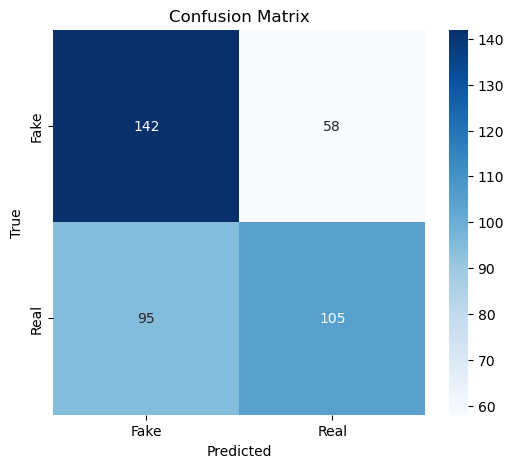

Classification Report:
              precision    recall  f1-score   support

        Fake       0.60      0.71      0.65       200
        Real       0.64      0.53      0.58       200

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.61       400
weighted avg       0.62      0.62      0.61       400



In [70]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Get predictions and true labels on the validation set
y_pred, y_true = get_all_preds_and_labels(late_fusion_model, fusion_val_loader, device)

# Confusion Matrix
cm2 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
target_names2 = ["Fake", "Real"]  # change if your classes have names
print("Classification Report:")
print(cr_LF2:=classification_report(y_true, y_pred, target_names=target_names2))

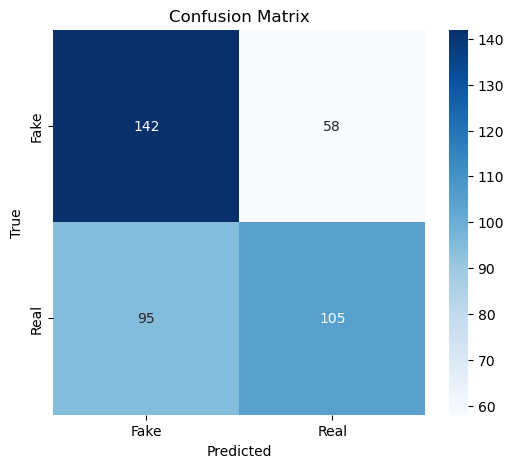

Classification Report:
              precision    recall  f1-score   support

        Fake       0.60      0.71      0.65       200
        Real       0.64      0.53      0.58       200

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.61       400
weighted avg       0.62      0.62      0.61       400



In [58]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Get predictions and true labels on the validation set
y_pred, y_true = get_all_preds_and_labels(late_fusion_model, fusion_val_loader, device)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
target_names = ["Fake", "Real"]  # change if your classes have names
print("Classification Report:")
print(cr_LF:=classification_report(y_true, y_pred, target_names=target_names))

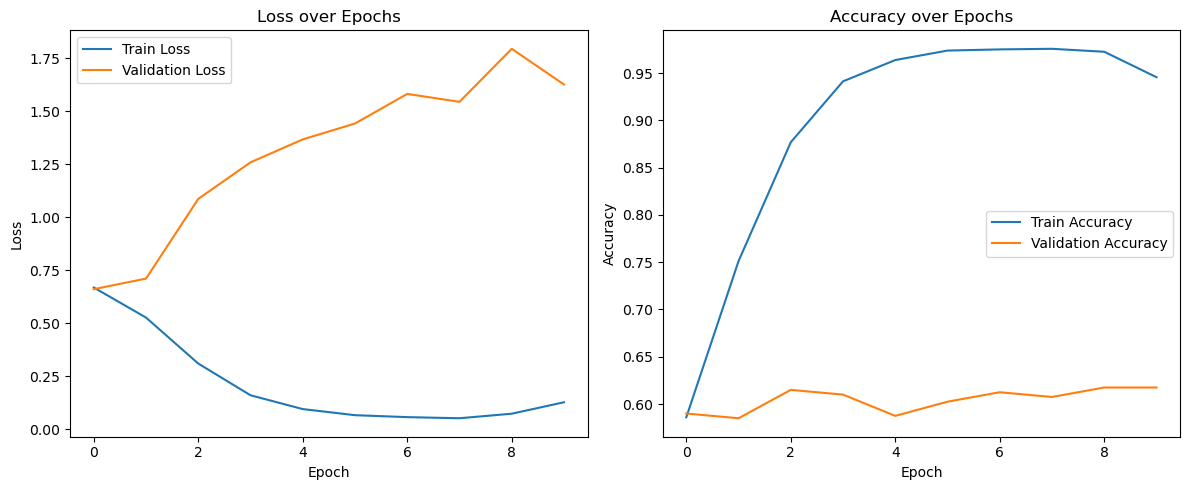

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

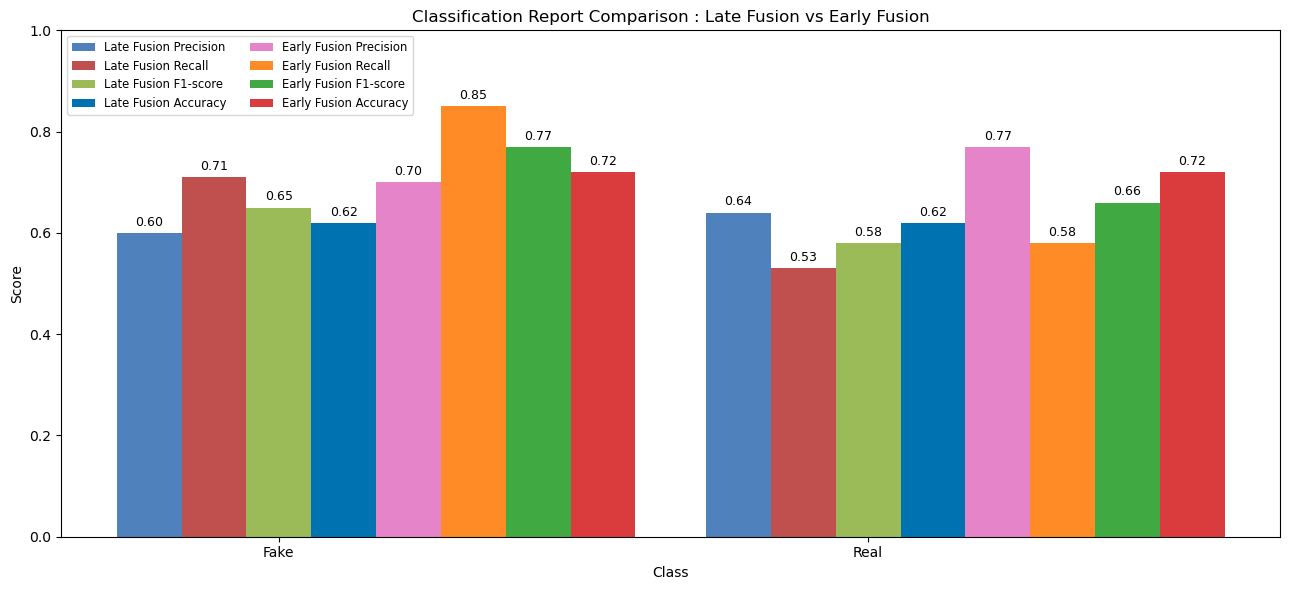

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Data from your reports
classes = ['Fake', 'Real']
metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy']

# Late fusion scores: [Fake, Real, Accuracy]
late_scores = [
    [0.60, 0.71, 0.65, 0.62],  # Fake
    [0.64, 0.53, 0.58, 0.62],  # Real
]
# Early fusion scores: [Fake, Real, Accuracy]
early_scores = [
    [0.70, 0.85, 0.77, 0.72],  # Fake
    [0.77, 0.58, 0.66, 0.72],  # Real
]

late_scores = np.array(late_scores)
early_scores = np.array(early_scores)

num_classes = len(classes)
num_metrics = len(metrics)
bar_width = 0.11
x = np.arange(num_classes)

# Colors for each metric
late_colors = ['#4F81BD', '#C0504D', '#9BBB59', '#0072B2']
early_colors = ['#E377C2', '#FF7F0E', '#2CA02C', '#D62728']

fig, ax = plt.subplots(figsize=(13, 6))

# Plot Late Fusion bars
for i, metric in enumerate(metrics):
    positions = x + i*bar_width - bar_width*2
    bars = ax.bar(positions, late_scores[:, i], width=bar_width, color=late_colors[i], label=f'Late Fusion {metric}')
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Plot Early Fusion bars
for i, metric in enumerate(metrics):
    positions = x + i*bar_width + bar_width*2
    bars = ax.bar(positions, early_scores[:, i], width=bar_width, color=early_colors[i], label=f'Early Fusion {metric}', alpha=0.9)
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# X-axis setup
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Classification Report Comparison : Late Fusion vs Early Fusion')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1)

# Legend (remove duplicates)
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), loc='upper left', fontsize='small', ncol=2)

plt.tight_layout()
plt.show()

# solving severe Overfitting

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
import re
from PIL import Image
import random

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

#  Vocab building and tokenizer 
def build_vocab(texts):
    tokens = []
    for text in texts:
        tokens += re.sub(r'[^a-zA-Z0-9\s]', '', str(text)).lower().split()
    vocab = {word: idx+1 for idx, word in enumerate(set(tokens))}
    vocab['<PAD>'] = 0
    return vocab

def simple_tokenizer(text, vocab, seq_length=128):
    tokens = re.sub(r'[^a-zA-Z0-9\s]', '', str(text)).lower().split()
    ids = [vocab.get(word, 0) for word in tokens]
    if len(ids) < seq_length:
        ids += [0] * (seq_length - len(ids))
    else:
        ids = ids[:seq_length]
    return torch.tensor(ids, dtype=torch.long)

#  Image transforms 
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#  Dataset 
class MultimodalDataset(Dataset):
    def __init__(self, df, vocab, seq_length=128, image_transform=None, text_col="text", label_col="label"):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.seq_length = seq_length
        self.image_transform = image_transform
        self.text_col = text_col
        self.label_col = label_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Image
        image = Image.open(row.image_path).convert("RGB")
        if self.image_transform:
            image = self.image_transform(image)
        # Text
        text_tensor = simple_tokenizer(row[self.text_col], self.vocab, self.seq_length)
        # Label
        label = torch.tensor(int(row[self.label_col]), dtype=torch.long)
        return {"image": image, "text": text_tensor}, label

import torch
import torch.nn as nn

#  LSTM Text Encoder with Dropout 
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout_p=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h_n = h_n[-1]  # [batch, hidden_dim]
        return self.dropout(h_n)

#  MobileNetV2 Feature Extractor with Dropout 
class MobileNetV2Features(nn.Module):
    def __init__(self, mobilenet, dropout_p=0.3):
        super().__init__()
        self.features = mobilenet.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_p)
        self.out_dim = mobilenet.last_channel

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.dropout(x)

#  Late Fusion Module 
class LateFusion(nn.Module):
    def __init__(self, encoders: nn.ModuleDict, fusion_module: nn.Module, head_module: nn.Module):
        super().__init__()
        self.encoders = encoders
        self.fusion_module = fusion_module
        self.head_module = head_module

    def forward(self, modalities):
        embeddings = []
        for key, encoder in self.encoders.items():
            emb = encoder(modalities[key])
            if emb.dim() == 1:
                emb = emb.unsqueeze(0)
            embeddings.append(emb)
        fused_input = torch.cat(embeddings, dim=1)
        fused = self.fusion_module(fused_input)
        return self.head_module(fused)

# Training & Evaluation Loops 
def train_fusion(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    for batch in dataloader:
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

def evaluate_fusion(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy


# Split your data
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    Finalized_Df, test_size=0.2, stratify=Finalized_Df['label'], random_state=42
)

# Build vocab from train only
vocab = build_vocab(train_df['text'])
seq_length = 128
embed_dim = 128
hidden_dim = 64

# Datasets and loaders
fusion_train_dataset = MultimodalDataset(train_df, vocab, seq_length, image_transform)
fusion_val_dataset = MultimodalDataset(val_df, vocab, seq_length, image_transform)
fusion_train_loader = DataLoader(fusion_train_dataset, batch_size=32, shuffle=True)
fusion_val_loader = DataLoader(fusion_val_dataset, batch_size=32, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image encoder
mobilenet = models.mobilenet_v2(pretrained=True)
image_model = MobileNetV2Features(mobilenet).to(device)
image_dim = image_model.out_dim

# Text encoder
text_model = LSTMClassifier(vocab_size=len(vocab), embed_dim=embed_dim, hidden_dim=hidden_dim).to(device)
text_dim = hidden_dim

#  Fusion and Head with Dropout 
fusion_module = nn.Sequential(
    nn.Linear(image_dim + text_dim, 256),
    nn.ReLU(),
    nn.Dropout(0.4),  # Dropout after ReLU
)
head_module = nn.Sequential(
    nn.Linear(256, 2),
    nn.Dropout(0.2)   # Optional: Dropout before final output
)

# Encoders dict
encoders = nn.ModuleDict({
    "image": image_model,
    "text": text_model,
})

# Late fusion model
late_fusion_model = LateFusion(encoders=encoders, fusion_module=fusion_module, head_module=head_module).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(late_fusion_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_fusion(late_fusion_model, fusion_train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_fusion(late_fusion_model, fusion_val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}, Accuracy: {val_acc:.4f}")

# Save model and vocab for reproducibility
torch.save(late_fusion_model.state_dict(), "late_fusion_model3.pth")
import pickle; pickle.dump(vocab, open("vocab.pkl3", "wb"))

c:\Users\Owner\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Owner\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1:
  Train Loss: 0.6921, Accuracy: 0.5391
  Val Loss:   0.6531, Accuracy: 0.6175
Epoch 2:
  Train Loss: 0.6240, Accuracy: 0.6573
  Val Loss:   0.6480, Accuracy: 0.6375
Epoch 3:
  Train Loss: 0.5293, Accuracy: 0.7448
  Val Loss:   0.7715, Accuracy: 0.6150
Epoch 4:
  Train Loss: 0.3619, Accuracy: 0.8437
  Val Loss:   0.8762, Accuracy: 0.5950
Epoch 5:
  Train Loss: 0.2176, Accuracy: 0.9162
  Val Loss:   1.0462, Accuracy: 0.6100
Epoch 6:
  Train Loss: 0.1677, Accuracy: 0.9331
  Val Loss:   1.1724, Accuracy: 0.5975
Epoch 7:
  Train Loss: 0.1367, Accuracy: 0.9406
  Val Loss:   1.5249, Accuracy: 0.5750
Epoch 8:
  Train Loss: 0.1092, Accuracy: 0.9468
  Val Loss:   1.4936, Accuracy: 0.6175
Epoch 9:
  Train Loss: 0.1021, Accuracy: 0.9475
  Val Loss:   1.6173, Accuracy: 0.6075
Epoch 10:
  Train Loss: 0.0906, Accuracy: 0.9512
  Val Loss:   1.6062, Accuracy: 0.6025


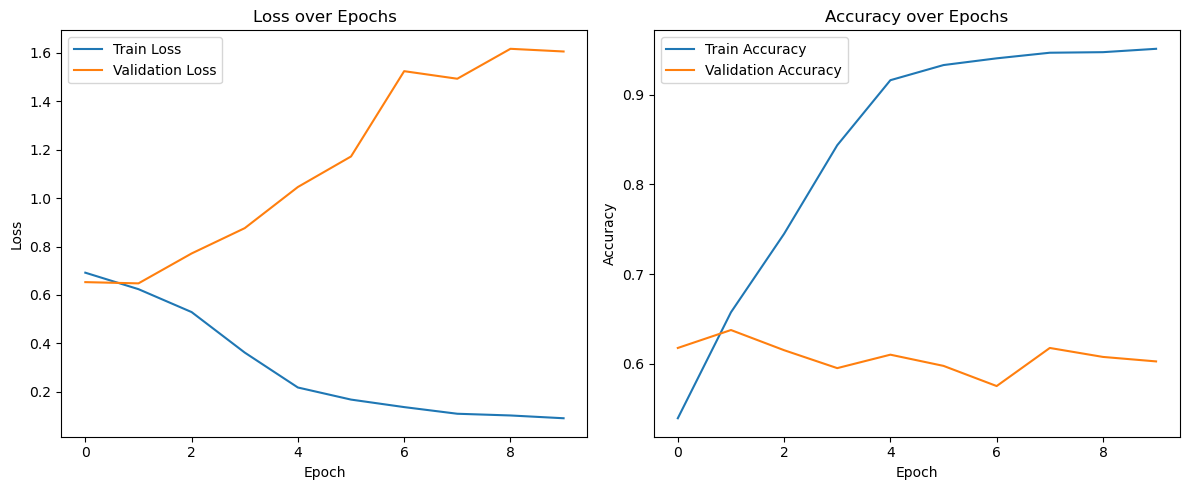

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

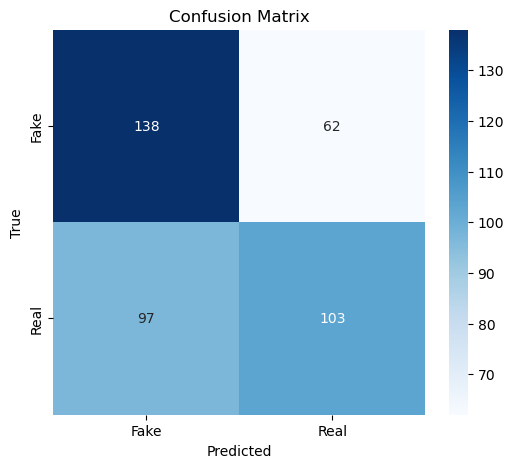

Classification Report:
              precision    recall  f1-score   support

        Fake       0.59      0.69      0.63       200
        Real       0.62      0.52      0.56       200

    accuracy                           0.60       400
   macro avg       0.61      0.60      0.60       400
weighted avg       0.61      0.60      0.60       400



In [77]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Get predictions and true labels on the validation set
y_pred, y_true = get_all_preds_and_labels(late_fusion_model, fusion_val_loader, device)

# Confusion Matrix
cm3 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
target_names3 = ["Fake", "Real"]  # change if your classes have names
print("Classification Report:")
print(cr_LF3 := classification_report(y_true, y_pred, target_names=target_names3))

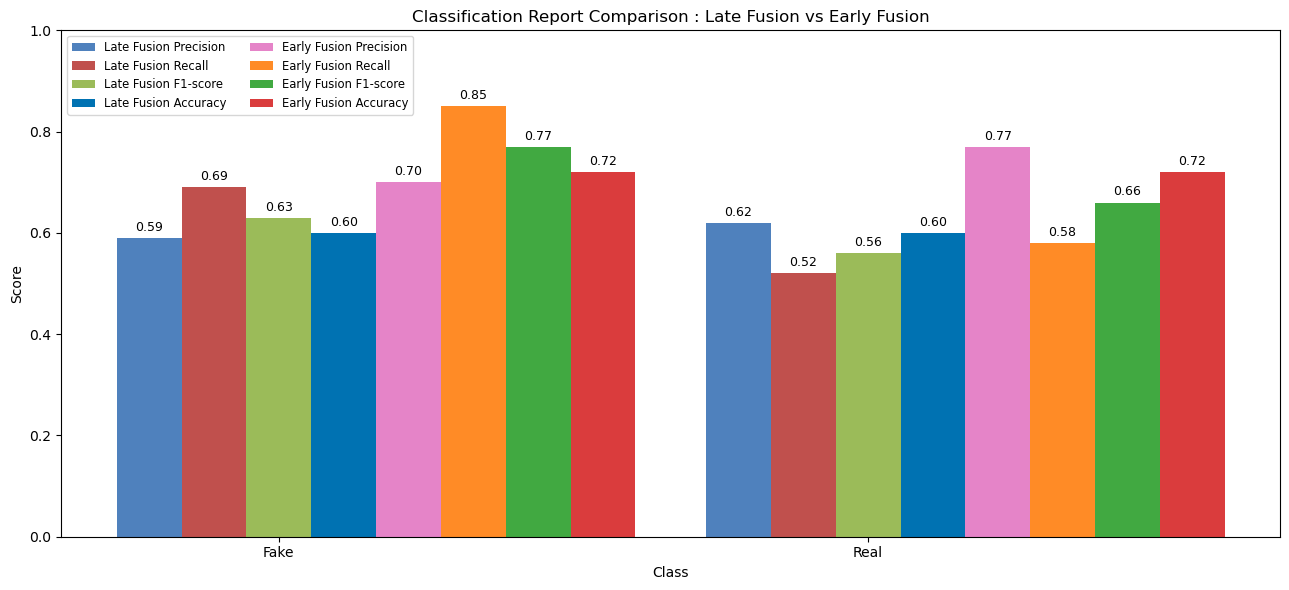

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Data from your reports
classes = ['Fake', 'Real']
metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy']

# Late fusion scores: [Fake, Real, Accuracy]
late_scores = [
    [0.59, 0.69, 0.63, 0.60],  # Fake
    [0.62, 0.52, 0.56, 0.60],  # Real
]
# Early fusion scores: [Fake, Real, Accuracy]
early_scores = [
    [0.70, 0.85, 0.77, 0.72],  # Fake
    [0.77, 0.58, 0.66, 0.72],  # Real
]

late_scores = np.array(late_scores)
early_scores = np.array(early_scores)

num_classes = len(classes)
num_metrics = len(metrics)
bar_width = 0.11
x = np.arange(num_classes)

# Colors for each metric
late_colors = ['#4F81BD', '#C0504D', '#9BBB59', '#0072B2']
early_colors = ['#E377C2', '#FF7F0E', '#2CA02C', '#D62728']

fig, ax = plt.subplots(figsize=(13, 6))

# Plot Late Fusion bars
for i, metric in enumerate(metrics):
    positions = x + i*bar_width - bar_width*2
    bars = ax.bar(positions, late_scores[:, i], width=bar_width, color=late_colors[i], label=f'Late Fusion {metric}')
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Plot Early Fusion bars
for i, metric in enumerate(metrics):
    positions = x + i*bar_width + bar_width*2
    bars = ax.bar(positions, early_scores[:, i], width=bar_width, color=early_colors[i], label=f'Early Fusion {metric}', alpha=0.9)
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# X-axis setup
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Classification Report Comparison : Late Fusion vs Early Fusion')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1)

# Legend (remove duplicates)
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), loc='upper left', fontsize='small', ncol=2)

plt.tight_layout()
plt.show()